In [210]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# IMPORT IMDB & BASIC CLEAN UP

In [49]:
# connect IMDB

con =sqlite3.connect('zippedData/im.db')

In [50]:
# IMDB select columns from movie_basics
# primary_name,original_title,genres,averagerating,numvotes
# order by primary_title

df_IMDB = pd.read_sql("""
SELECT b.primary_title,b.original_title,b.genres AS IMDB_genres,r.averagerating AS IMDB_ratings,r.numvotes AS IMDB_nvotes
FROM movie_ratings AS r
LEFT JOIN movie_basics AS b
ON r.movie_id = b.movie_id
ORDER BY b.primary_title
""",con)
df_IMDB.head()

,primary_title,original_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
0,!Women Art Revolution,Women Art Revolution,Documentary,6.9,196
1,#1 Serial Killer,#1 Serial Killer,Horror,5.6,40
2,#5,#5,"Biography,Comedy,Fantasy",6.8,6
3,#66,#66,Action,5.3,18
4,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21


In [51]:
df_IMDB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   primary_title   73856 non-null  object 
 1   original_title  73856 non-null  object 
 2   IMDB_genres     73052 non-null  object 
 3   IMDB_ratings    73856 non-null  float64
 4   IMDB_nvotes     73856 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 2.8+ MB


In [52]:
df_IMDB.describe()

,IMDB_ratings,IMDB_nvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


In [53]:
df_IMDB = df_IMDB.dropna()

In [54]:
df_IMDB.isna().sum()

primary_title     0
original_title    0
IMDB_genres       0
IMDB_ratings      0
IMDB_nvotes       0
dtype: int64

In [55]:
# check the outliers

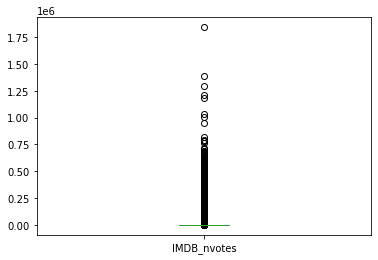

In [56]:
df_IMDB['IMDB_nvotes'].plot(kind='box');
# very skewed, some
# needs to trim

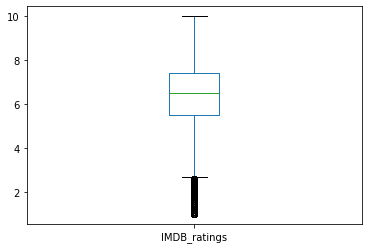

In [57]:
df_IMDB['IMDB_ratings'].plot(kind='box');
# skewed, but bad movie maybe not mean bad profit?

In [58]:
# which movie has the best rating

<AxesSubplot:ylabel='Frequency'>

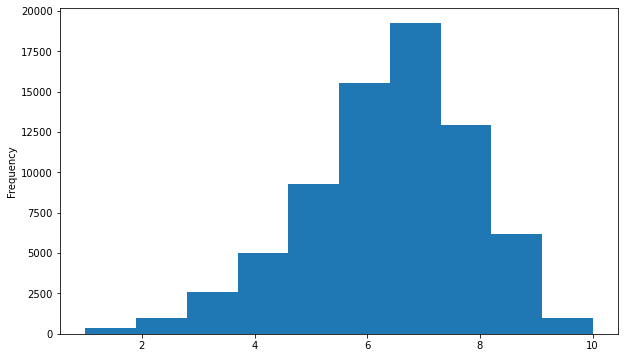

In [59]:
# check overall movie ratings
df_IMDB['IMDB_ratings'].plot(kind='hist',bins=10,figsize=(10,6))
# 6.9 is the median

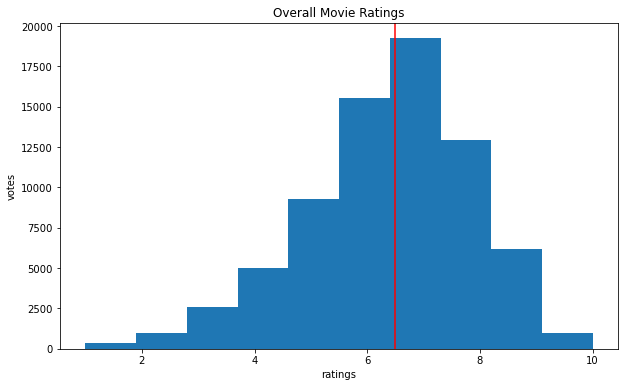

In [60]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(df_IMDB['IMDB_ratings'],bins=10)
ax.axvline(df_IMDB['IMDB_ratings'].median(),c='r')
# median is 6.9
ax.set_title('Overall Movie Ratings')
ax.set_xlabel('ratings')
ax.set_ylabel('votes');

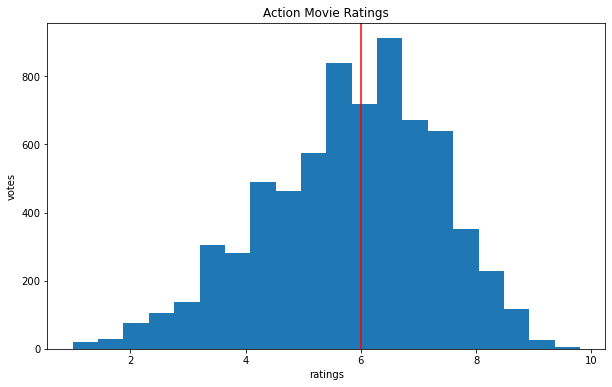

In [61]:
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(df_IMDB[df_IMDB['IMDB_genres'].str.contains('Action')]['IMDB_ratings'],bins=20)
ax.axvline(df_IMDB[df_IMDB['IMDB_genres'].str.contains('Action')]['IMDB_ratings'].median(),c='r')
ax.set_title('Action Movie Ratings')
ax.set_xlabel('ratings')
ax.set_ylabel('votes');

In [62]:
df_IMDB[df_IMDB['IMDB_genres'].str.contains('Action')]['IMDB_ratings'].median()

6.0

<AxesSubplot:ylabel='Frequency'>

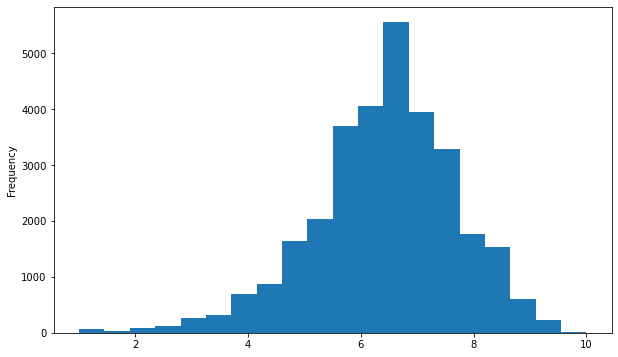

In [63]:
# Drama movie overall ratings
df_IMDB[df_IMDB['IMDB_genres'].str.contains('Drama')]['IMDB_ratings'].plot(kind='hist',bins=20,figsize=(10,6))

create a df of genres and its ratings
best rating and median ratings

but first use TM to filter the IMDB
IMDB has many not commercial movie info

# IMPORT TM & MERGE WITH IMDB

In [64]:
# get TM movies CSV
# start to clean it
# use it to filter IMDB

df_tm_movies = pd.read_csv('zippedData/tmdb.movies.csv')
df_tm_movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [65]:
df_tm_movies_clean = df_tm_movies[['title','original_title','release_date','vote_average','vote_count']]
df_tm_movies_clean

,title,original_title,release_date,vote_average,vote_count
0,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1,2010-11-19,7.7,10788
1,How to Train Your Dragon,How to Train Your Dragon,2010-03-26,7.7,7610
2,Iron Man 2,Iron Man 2,2010-05-07,6.8,12368
3,Toy Story,Toy Story,1995-11-22,7.9,10174
4,Inception,Inception,2010-07-16,8.3,22186
...,...,...,...,...,...
26512,Laboratory Conditions,Laboratory Conditions,2018-10-13,0.0,1
26513,_EXHIBIT_84xxx_,_EXHIBIT_84xxx_,2018-05-01,0.0,1
26514,The Last One,The Last One,2018-10-01,0.0,1
26515,Trailer Made,Trailer Made,2018-06-22,0.0,1


In [66]:
# join IMDB with TM

df_join = pd.merge(df_IMDB,df_tm_movies_clean,how='inner',left_on='primary_title',right_on='title')

In [67]:
df_join

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,title,original_title_y,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,#ALLMYMOVIES,#ALLMYMOVIES,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,#Captured,#Captured,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,#FollowFriday,#FollowFriday,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,#Horror,#Horror,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,#Lucky Number,#Lucky Number,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...,...,...
19874,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,i hate myself :),i hate myself :),2013-07-19,8.0,1
19875,iGirlfriend,iGirlfriend,Comedy,2.7,200,iGirlfriend,iGirlfriend,2017-01-15,4.0,4
19876,iSteve,iSteve,"Biography,Comedy",5.3,1098,iSteve,iSteve,2013-04-14,4.8,22
19877,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,xXx: Return of Xander Cage,xXx: Return of Xander Cage,2017-01-20,5.6,2452


In [68]:
df_join_clean = df_join.drop(columns=['title','original_title_y'])

In [69]:
df_join_clean = df_join_clean.drop_duplicates()

In [70]:
df_join_clean['release_date'] = pd.to_datetime(df_join_clean['release_date'])

In [71]:
df_join_clean['IMDB_genres'].astype('category')

0                      Documentary
1                         Thriller
2                         Thriller
3               Crime,Drama,Horror
4                           Comedy
                   ...            
19874     Comedy,Documentary,Drama
19875                       Comedy
19876             Biography,Comedy
19877    Action,Adventure,Thriller
19878                  Documentary
Name: IMDB_genres, Length: 18830, dtype: category
Categories (617, object): ['Action', 'Action,Adventure', 'Action,Adventure,Animation', 'Action,Adventure,Biography', ..., 'Thriller,War', 'Thriller,Western', 'War', 'Western']

In [72]:
df_join_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18830 entries, 0 to 19878
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   primary_title     18830 non-null  object        
 1   original_title_x  18830 non-null  object        
 2   IMDB_genres       18830 non-null  object        
 3   IMDB_ratings      18830 non-null  float64       
 4   IMDB_nvotes       18830 non-null  int64         
 5   release_date      18830 non-null  datetime64[ns]
 6   vote_average      18830 non-null  float64       
 7   vote_count        18830 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [73]:
df_join_clean.describe()

,IMDB_ratings,IMDB_nvotes,vote_average,vote_count
count,18830.000000,1.883000e+04,18830.000000,18830.000000
mean,5.915157,1.364132e+04,5.770664,266.307807
std,1.399405,6.003093e+04,1.713190,1113.087212
min,1.100000,5.000000e+00,0.000000,1.000000
25%,5.000000,8.400000e+01,4.900000,2.000000
50%,6.100000,3.860000e+02,6.000000,8.000000
75%,6.900000,2.538000e+03,6.900000,53.000000
max,9.800000,1.841066e+06,10.000000,22186.000000


In [74]:
df_join_clean

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2
...,...,...,...,...,...,...,...,...
19874,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,2013-07-19,8.0,1
19875,iGirlfriend,iGirlfriend,Comedy,2.7,200,2017-01-15,4.0,4
19876,iSteve,iSteve,"Biography,Comedy",5.3,1098,2013-04-14,4.8,22
19877,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,2017-01-20,5.6,2452


# EDA WITH THE GENRES

In [75]:
# get a df for genre & ratings from IMDB

df_IMDB_genre_ratings = df_join_clean[['primary_title','IMDB_genres','IMDB_ratings','IMDB_nvotes']]

In [76]:
df_IMDB_genre_ratings.head()

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
0,#ALLMYMOVIES,Documentary,8.3,21
1,#Captured,Thriller,2.8,212
2,#FollowFriday,Thriller,2.8,186
3,#Horror,"Crime,Drama,Horror",3.0,3092
4,#Lucky Number,Comedy,5.1,425


In [77]:
df_IMDB_genre_ratings.columns = ['title', 'genres', 'ratings', 'nvotes']

In [78]:
df_IMDB_genre_ratings = df_IMDB_genre_ratings.sort_values(by=['genres','ratings'],ascending=True)
df_IMDB_genre_ratings.head()

,title,genres,ratings,nvotes
18885,VS: The Movie,Action,2.1,68
8907,King Arthur and the Knights of the Round Table,Action,2.2,471
10556,Monster Island,Action,2.5,111
18871,Urgency,Action,2.6,207
8171,In the Name of Ben Hur,Action,2.7,737


In [79]:
df_IMDB_genre_ratings

,title,genres,ratings,nvotes
18885,VS: The Movie,Action,2.1,68
8907,King Arthur and the Knights of the Round Table,Action,2.2,471
10556,Monster Island,Action,2.5,111
18871,Urgency,Action,2.6,207
8171,In the Name of Ben Hur,Action,2.7,737
...,...,...,...,...
16445,The Killer,Western,6.0,1671
17264,The Redemption of Henry Myers,Western,6.5,267
15614,The Divide,Western,7.9,7
15615,The Divide,Western,7.9,7


<AxesSubplot:xlabel='genres'>

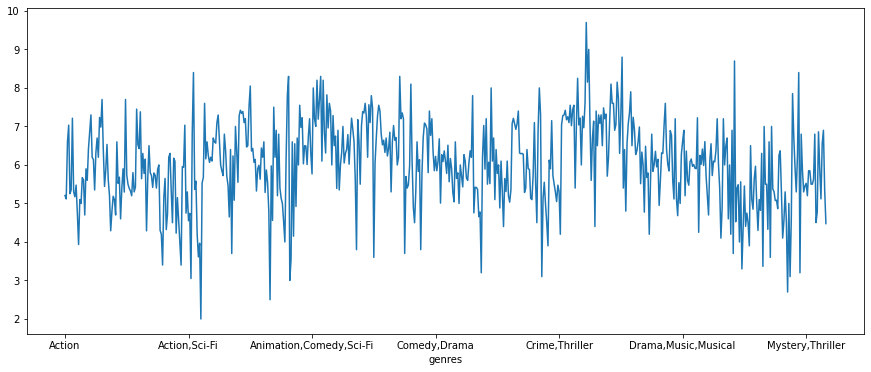

In [80]:
df_IMDB_genre_ratings.groupby(by='genres')['ratings'].mean().plot(figsize=(15,6))



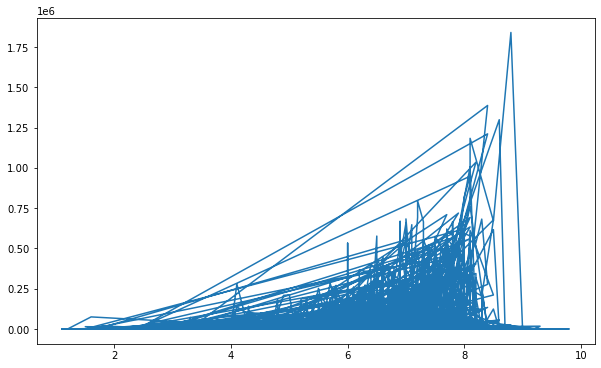

In [81]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(df_IMDB_genre_ratings['ratings'],df_IMDB_genre_ratings['nvotes']);

In [82]:
df_IMDB_genre_ratings.describe()

,ratings,nvotes
count,18830.000000,1.883000e+04
mean,5.915157,1.364132e+04
std,1.399405,6.003093e+04
min,1.100000,5.000000e+00
25%,5.000000,8.400000e+01
50%,6.100000,3.860000e+02
75%,6.900000,2.538000e+03
max,9.800000,1.841066e+06


In [83]:
# find unique genres
unique_genres = []

for g in df_join_clean['IMDB_genres']:
    temp = g.split(',')
    for t in temp:
        if t not in unique_genres:
            unique_genres.append(t)
        
print(unique_genres)
print(len(unique_genres))

['Documentary', 'Thriller', 'Crime', 'Drama', 'Horror', 'Comedy', 'Romance', 'Adventure', 'Action', 'Sport', 'News', 'Music', 'History', 'Family', 'Mystery', 'Biography', 'Sci-Fi', 'Fantasy', 'Animation', 'War', 'Western', 'Musical', 'Reality-TV', 'Adult', 'Game-Show']
25


In [103]:
df_genre = df_join_clean[['primary_title','IMDB_genres','IMDB_ratings','IMDB_nvotes']]
df_genre

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
0,#ALLMYMOVIES,Documentary,8.3,21
1,#Captured,Thriller,2.8,212
2,#FollowFriday,Thriller,2.8,186
3,#Horror,"Crime,Drama,Horror",3.0,3092
4,#Lucky Number,Comedy,5.1,425
...,...,...,...,...
19874,i hate myself :),"Comedy,Documentary,Drama",7.7,46
19875,iGirlfriend,Comedy,2.7,200
19876,iSteve,"Biography,Comedy",5.3,1098
19877,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976


In [104]:
# turn IMDB_genres to list
df_genre['IMDB_genres'] = df_genre['IMDB_genres'].apply(lambda x: x.split(','))

<ipython-input-104-5b93a0187e72>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['IMDB_genres'] = df_genre['IMDB_genres'].apply(lambda x: x.split(','))


In [105]:
len(df_genre['IMDB_genres'])

18830

In [106]:
df_genre['n of genres'] = df_genre['IMDB_genres'].map(lambda x: len(x))

<ipython-input-106-ae1852318d5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['n of genres'] = df_genre['IMDB_genres'].map(lambda x: len(x))


In [107]:
df_genre

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes,n of genres
0,#ALLMYMOVIES,[Documentary],8.3,21,1
1,#Captured,[Thriller],2.8,212,1
2,#FollowFriday,[Thriller],2.8,186,1
3,#Horror,"[Crime, Drama, Horror]",3.0,3092,3
4,#Lucky Number,[Comedy],5.1,425,1
...,...,...,...,...,...
19874,i hate myself :),"[Comedy, Documentary, Drama]",7.7,46,3
19875,iGirlfriend,[Comedy],2.7,200,1
19876,iSteve,"[Biography, Comedy]",5.3,1098,2
19877,xXx: Return of Xander Cage,"[Action, Adventure, Thriller]",5.2,77976,3


In [108]:
df_genre['n of genres'] = df_genre['n of genres'].astype(str)

<ipython-input-108-c7a9d4973c82>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre['n of genres'] = df_genre['n of genres'].astype(str)


In [109]:
type(df_genre['n of genres'][0])

str

In [110]:
df_genre.groupby(by=['n of genres']).count()

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes
n of genres,,,,
1,6763,6763,6763,6763
2,5184,5184,5184,5184
3,6883,6883,6883,6883


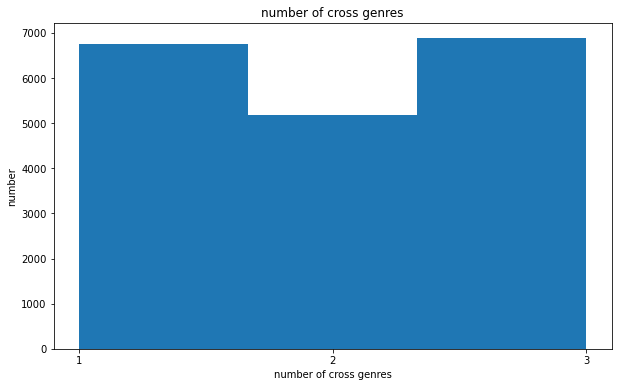

In [111]:
fig,ax = plt.subplots(figsize = (10,6))
ax.hist(df_genre['n of genres'].sort_values(),bins=3)
ax.set_title('number of cross genres')
ax.set_xlabel('number of cross genres')
ax.set_ylabel('number');

# 1/2/3 genres are similar

# MOVIE CHANGES THROUGH TIME

movie made every year, movie genre changes, budget changes, gross changes, etc.

In [113]:
df_join_clean

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count,Release_Year
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4,2015
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6,2017
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7,2016
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102,2015
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2,2015
...,...,...,...,...,...,...,...,...,...
19874,i hate myself :),i hate myself :),"Comedy,Documentary,Drama",7.7,46,2013-07-19,8.0,1,2013
19875,iGirlfriend,iGirlfriend,Comedy,2.7,200,2017-01-15,4.0,4,2017
19876,iSteve,iSteve,"Biography,Comedy",5.3,1098,2013-04-14,4.8,22,2013
19877,xXx: Return of Xander Cage,xXx: Return of Xander Cage,"Action,Adventure,Thriller",5.2,77976,2017-01-20,5.6,2452,2017


In [114]:
# genre changes through years
# first, group by year

df_join_clean.loc[:,'Release_Year'] = pd.DatetimeIndex(df_join_clean.release_date).year

df_join_clean.head()

,primary_title,original_title_x,IMDB_genres,IMDB_ratings,IMDB_nvotes,release_date,vote_average,vote_count,Release_Year
0,#ALLMYMOVIES,#ALLMYMOVIES,Documentary,8.3,21,2015-11-12,9.0,4,2015
1,#Captured,#Captured,Thriller,2.8,212,2017-10-11,3.2,6,2017
2,#FollowFriday,#FollowFriday,Thriller,2.8,186,2016-07-01,3.2,7,2016
3,#Horror,#Horror,"Crime,Drama,Horror",3.0,3092,2015-11-20,3.3,102,2015
4,#Lucky Number,#Lucky Number,Comedy,5.1,425,2015-09-01,6.0,2,2015


In [115]:
df_join_clean.groupby(by='Release_Year')['Release_Year'].count()

Release_Year
1949       2
1964       3
1968       2
1976       1
1978       1
1985       1
1986       3
1988       2
1995       1
1997       1
2000       3
2003       1
2005       4
2006       1
2007       1
2008       2
2009      11
2010    1454
2011    1847
2012    1879
2013    2361
2014    2337
2015    2357
2016    2317
2017    2222
2018    1935
2019      81
Name: Release_Year, dtype: int64

Text(0.5, 1.0, 'number of movies made through the years')

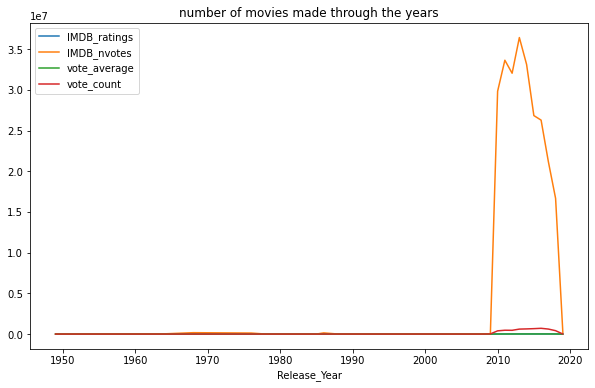

In [117]:
df_join_clean.groupby(by='Release_Year').sum().plot(figsize=(10,6))

plt.title('number of movies made through the years')

# seems like making 2000+- movies each year
# the lower number in the early years, 
# maybe cause to no data tracking yet

In [129]:
# make a dictionary of unique genres
dict_genres = {key:0 for key in unique_genres}

for lst in df_genre['IMDB_genres']:
    for value in lst:
        if value in unique_genres:
            dict_genres[value] += 1
            
print(dict_genres)

{'Documentary': 3423, 'Thriller': 3483, 'Crime': 1739, 'Drama': 8635, 'Horror': 3227, 'Comedy': 4252, 'Romance': 1874, 'Adventure': 1336, 'Action': 2367, 'Sport': 364, 'News': 151, 'Music': 485, 'History': 639, 'Family': 827, 'Mystery': 1212, 'Biography': 1091, 'Sci-Fi': 1006, 'Fantasy': 702, 'Animation': 465, 'War': 227, 'Western': 123, 'Musical': 147, 'Reality-TV': 3, 'Adult': 1, 'Game-Show': 1}


In [119]:
df_genre

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes,n of genres
0,#ALLMYMOVIES,[Documentary],8.3,21,1
1,#Captured,[Thriller],2.8,212,1
2,#FollowFriday,[Thriller],2.8,186,1
3,#Horror,"[Crime, Drama, Horror]",3.0,3092,3
4,#Lucky Number,[Comedy],5.1,425,1
...,...,...,...,...,...
19874,i hate myself :),"[Comedy, Documentary, Drama]",7.7,46,3
19875,iGirlfriend,[Comedy],2.7,200,1
19876,iSteve,"[Biography, Comedy]",5.3,1098,2
19877,xXx: Return of Xander Cage,"[Action, Adventure, Thriller]",5.2,77976,3


In [141]:
df_genre['IMDB_ratings'][2000]

2.9

In [145]:
for genre in unique_genres:        #genre is one of the unique genres from the list
    df_genre[genre] = 0
    for ind, value in enumerate(df_genre['IMDB_genres']): # index is the index of the row - row is 
        if (value is not None):
            if (genre in value):
                df_genre[genre][ind]=1
df_genre

<ipython-input-145-93363f9c8728>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre[genre] = 0
<ipython-input-145-93363f9c8728>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_genre[genre][ind]=1
C:\Users\qwswe\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3417: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_

,primary_title,IMDB_genres,IMDB_ratings,IMDB_nvotes,n of genres,Documentary,Thriller,Crime,Drama,Horror,...,Biography,Sci-Fi,Fantasy,Animation,War,Western,Musical,Reality-TV,Adult,Game-Show
0,#ALLMYMOVIES,[Documentary],8.3,21,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#Captured,[Thriller],2.8,212,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,#FollowFriday,[Thriller],2.8,186,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,#Horror,"[Crime, Drama, Horror]",3.0,3092,3,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,#Lucky Number,[Comedy],5.1,425,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19874,i hate myself :),"[Comedy, Documentary, Drama]",7.7,46,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19875,iGirlfriend,[Comedy],2.7,200,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19876,iSteve,"[Biography, Comedy]",5.3,1098,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19877,xXx: Return of Xander Cage,"[Action, Adventure, Thriller]",5.2,77976,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
df_ratings = pd.DataFrame(df_genre.IMDB_ratings)
for i,x in enumerate(unique_genres):
    df_ratings[x] = df_genre[x] * df_genre.IMDB_ratings
df_ratings

,IMDB_ratings,Documentary,Thriller,Crime,Drama,Horror,Comedy,Romance,Adventure,Action,...,Biography,Sci-Fi,Fantasy,Animation,War,Western,Musical,Reality-TV,Adult,Game-Show
0,8.3,8.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.8,0.0,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.8,0.0,2.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.1,0.0,0.0,0.0,0.0,0.0,5.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19874,7.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19875,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19876,5.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19877,5.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [186]:
df_ratings_sum = df_ratings.sum(axis=0)[1:].sort_index()
df_ratings_sum = df_ratings_sum.to_frame()

In [187]:
type(df_ratings_sum)

pandas.core.frame.DataFrame

In [181]:
df_genre_counts = pd.DataFrame.from_dict(dict_genres,orient='index',columns=['counts']).sort_index()
df_genre_counts

,counts
Action,2367
Adult,1
Adventure,1336
Animation,465
Biography,1091
Comedy,4252
Crime,1739
Documentary,3423
Drama,8635
Family,827


In [193]:
df_gr = df_ratings_sum.merge(df_genre_counts,left_index=True,right_index=True)

In [196]:
df_gr.columns = ['totalratings','counts']

In [197]:
df_gr

,totalratings,counts
Action,13209.8,2367
Adult,6.7,1
Adventure,7365.2,1336
Animation,2524.1,465
Biography,6033.5,1091
Comedy,23893.1,4252
Crime,9726.7,1739
Documentary,18973.6,3423
Drama,48523.9,8635
Family,4644.4,827


In [202]:
df_gr['avgr'] = df_gr['totalratings'] / df_gr['counts']
df_gr = df_gr.sort_values(by='avgr')

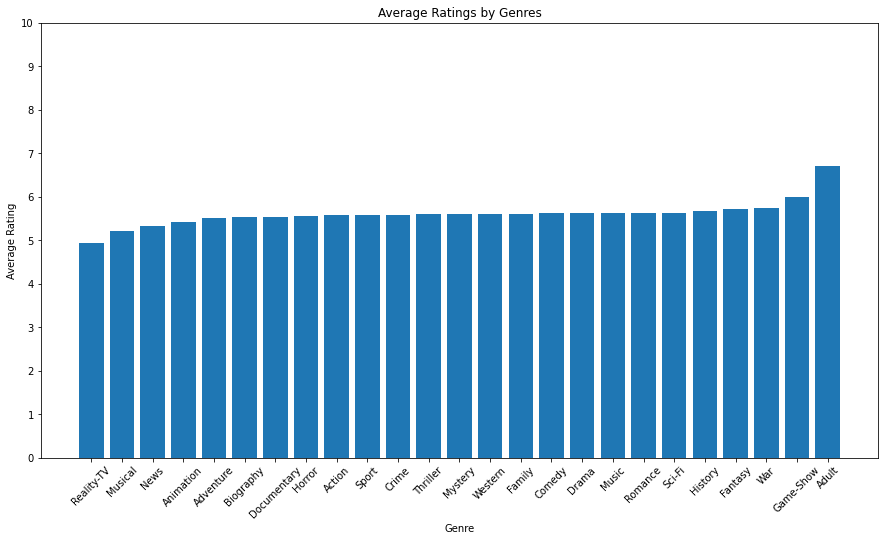

In [212]:
fig,ax = plt.subplots(figsize = (15,8))
ax.bar(df_gr.index.values,df_gr.avgr,data=df_gr)
plt.xticks(rotation = 45)
plt.yticks(np.arange(0, 11, step=1))
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_title('Average Ratings by Genres');

In [148]:
col_names = list(df_ratings.columns)[1:]
ratings = df_ratings.sum(axis=0)[1:]/(len(df_ratings.columns)-1)

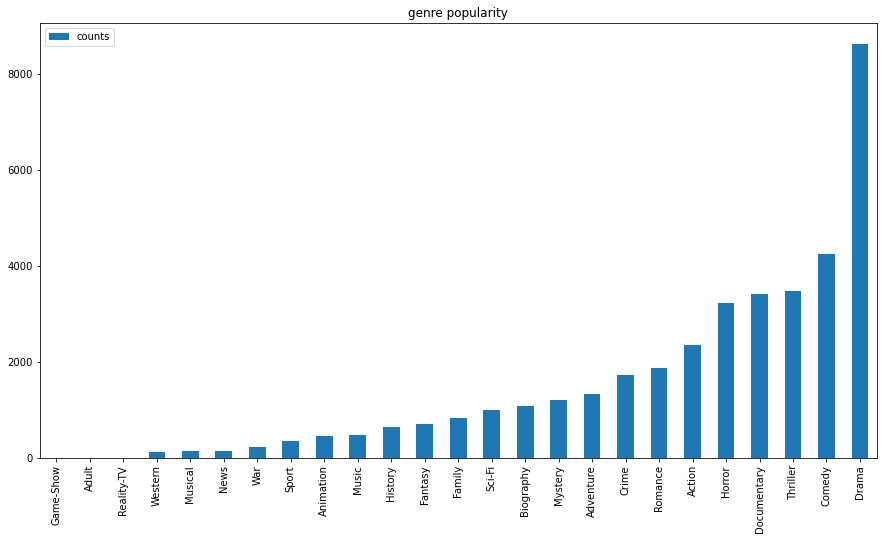

In [45]:
df_genre_counts.plot(kind='bar',figsize=(15,8))
plt.title('genre popularity');

# SOME ATTEMPTS

In [ ]:
# check the new df's rating

<AxesSubplot:>

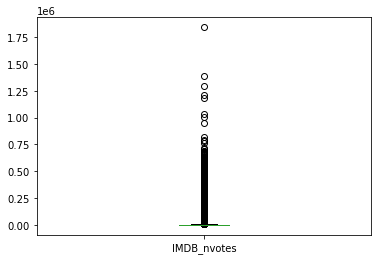

In [92]:
df_join_clean['IMDB_nvotes'].plot(kind='box')

In [ ]:
# different genres/genres combos' rating

In [101]:
df_join_clean.groupby(by='IMDB_genres')['IMDB_ratings'].mean()

IMDB_genres
Action                        5.206000
Action,Adventure              5.117857
Action,Adventure,Animation    6.592453
Action,Adventure,Biography    7.033333
Action,Adventure,Comedy       5.253608
                                ...   
Thriller                      5.118699
Thriller,War                  6.550000
Thriller,Western              6.900000
War                           5.360000
Western                       4.477419
Name: IMDB_ratings, Length: 617, dtype: float64

In [103]:
# top genres' rating
df_join_clean['IMDB_genres'].value_counts()

Drama                            2257
Documentary                      1709
Horror                            841
Comedy                            831
Comedy,Drama                      646
                                 ... 
Animation,Documentary,History       1
Documentary,News,War                1
Action,Thriller,Western             1
Drama,History,Mystery               1
Fantasy,Romance,Thriller            1
Name: IMDB_genres, Length: 617, dtype: int64

In [ ]:
first_20_genres = 

In [108]:
df_join_clean[df_join_clean['IMDB_genres']=='Drama'].IMDB_ratings.mean()

6.270536109880372

In [ ]:
# find the most popular genre and genre combos

In [109]:
first_100_genres = df_join_clean['IMDB_genres'].value_counts().head(100)

In [110]:
type(first_100_genres)

pandas.core.series.Series

In [ ]:
first_100_genres[:10].plot(kind='bar')

<AxesSubplot:>

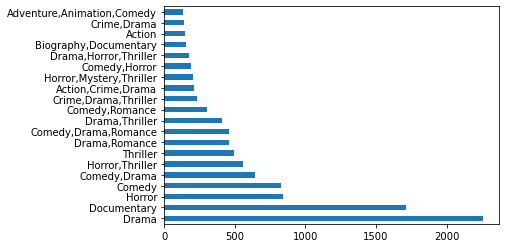

In [102]:
df_join_clean['IMDB_genres'].value_counts()[:20].plot(kind='barh')

In [ ]:
# find unique genres
# try find the ones without comma
# 21

individual_genre = df_join_clean[df_join_clean['IMDB_genres'].str.contains(',')==False]['IMDB_genres'].unique()

In [ ]:
df_game_movie = pd.read_csv('zippedData/List_of_highest-grossing_films_based_on_video_games_wikipedia.csv')

In [ ]:
df_game_movie_clean = df_game_movie[['Title','Based on video game(s)','Original game publisher(s)','Distributor','Format']]

In [ ]:
df_game_movie_clean.info()

In [ ]:
df_game_movie_clean['Format'].value_counts().plot(kind='barh')

In [ ]:
df_game_movie_clean.head(10)

In [ ]:
# combine BOM/TN with LIST of wikipedia game movie list

In [69]:
df_tn = pd.read_csv('zippedData/tn.movie_budgets.csv')

In [70]:
df_tn

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [ ]:
df_join_wiki_tn = pd.merge(df_game_movie_clean,df_tn,how='left',right_on='movie',left_on='Title')

In [ ]:
df_join_wiki_tn

In [ ]:
df_tn[df_tn['movie'].str.contains('Pikachu')]['movie']='Detective Pikachu'

In [ ]:
# find dataset on Kaggle
# https://www.kaggle.com/datasets/bcruise/film-adaptations-of-video-games

In [ ]:
df_kaggle_game = pd.read_csv('zippedData/video_game_films.csv')

In [ ]:
df_kaggle_game.head()

In [ ]:
df_kaggle_game['Release date'] = pd.to_datetime(df_kaggle_game['Release date'])

In [ ]:
df_kaggle_game['Release date'].value_counts()